In [39]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import cv2
import numpy as np
from ImageGenerator import ImageAugmentation
from sklearn.metrics import confusion_matrix, classification_report
import concurrent
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.utils import plot_model


In [40]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [41]:
dict_gender = {
    0: 'male',
    1: 'female'
}
dict_race = {
    0: 'white',
    1: 'black',
    2: 'asian',
    3: 'indian',
    4: 'others'
}

dict_age = {
    0: 'child',
    1: 'teenager',
    2: 'adult',
    3: 'old',
}

In [42]:
def load_data(directory):
    dict_data = {
        'image': [],
        'age': [],
        'gender': [],
        'race': [],
    }
    for file in os.listdir(directory):
        label = file.split('_')
        dict_data['image'].append(file)
        dict_data['age'].append(int(label[0]))
        dict_data['gender'].append(int(label[1]))
        dict_data['race'].append(int(label[2]))
    
    df_data = pd.DataFrame(dict_data)
    return df_data


In [43]:
BASE_DIR = 'data/face_age_gender_race/cropped'
df_data = load_data(BASE_DIR)

In [44]:
df_data.head()

,image,age,gender,race
0,100_0_0_20170112213500903.jpg.chip.jpg,100,0,0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,0,0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0
3,100_1_0_20170112213001988.jpg.chip.jpg,100,1,0
4,100_1_0_20170112213303693.jpg.chip.jpg,100,1,0


In [45]:
bins = [0, 12, 18, 40, 116]
labels = [0, 1, 2, 3]
df_data['age_group'] = pd.cut(df_data['age'], bins=bins, labels=labels)

In [46]:
df_data.head()

,image,age,gender,race,age_group
0,100_0_0_20170112213500903.jpg.chip.jpg,100,0,0,3
1,100_0_0_20170112215240346.jpg.chip.jpg,100,0,0,3
2,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0,3
3,100_1_0_20170112213001988.jpg.chip.jpg,100,1,0,3
4,100_1_0_20170112213303693.jpg.chip.jpg,100,1,0,3


In [47]:
def plot_label_distribution(labels):
    unique_labels = np.unique(labels, axis=0)
    counts = np.zeros(len(unique_labels))
    for i, label in enumerate(unique_labels):
        counts[i] = np.sum(np.all(labels == label, axis=1))
    plt.figure(figsize=(10, 15))
    plt.barh(range(len(unique_labels)), counts)
    plt.ylabel('Labels')
    plt.xlabel('Count')
    plt.title('Label Distribution')
    plt.yticks(range(len(unique_labels)), [f'{dict_age[label[0]]} {dict_gender[label[1]]} {dict_race[label[2]]} {label}' for label in unique_labels], fontsize=8)
    for i, v in enumerate(counts):
        plt.text(v + 0.5, i, str(int(v)), va='center', fontsize=8)
    plt.show()

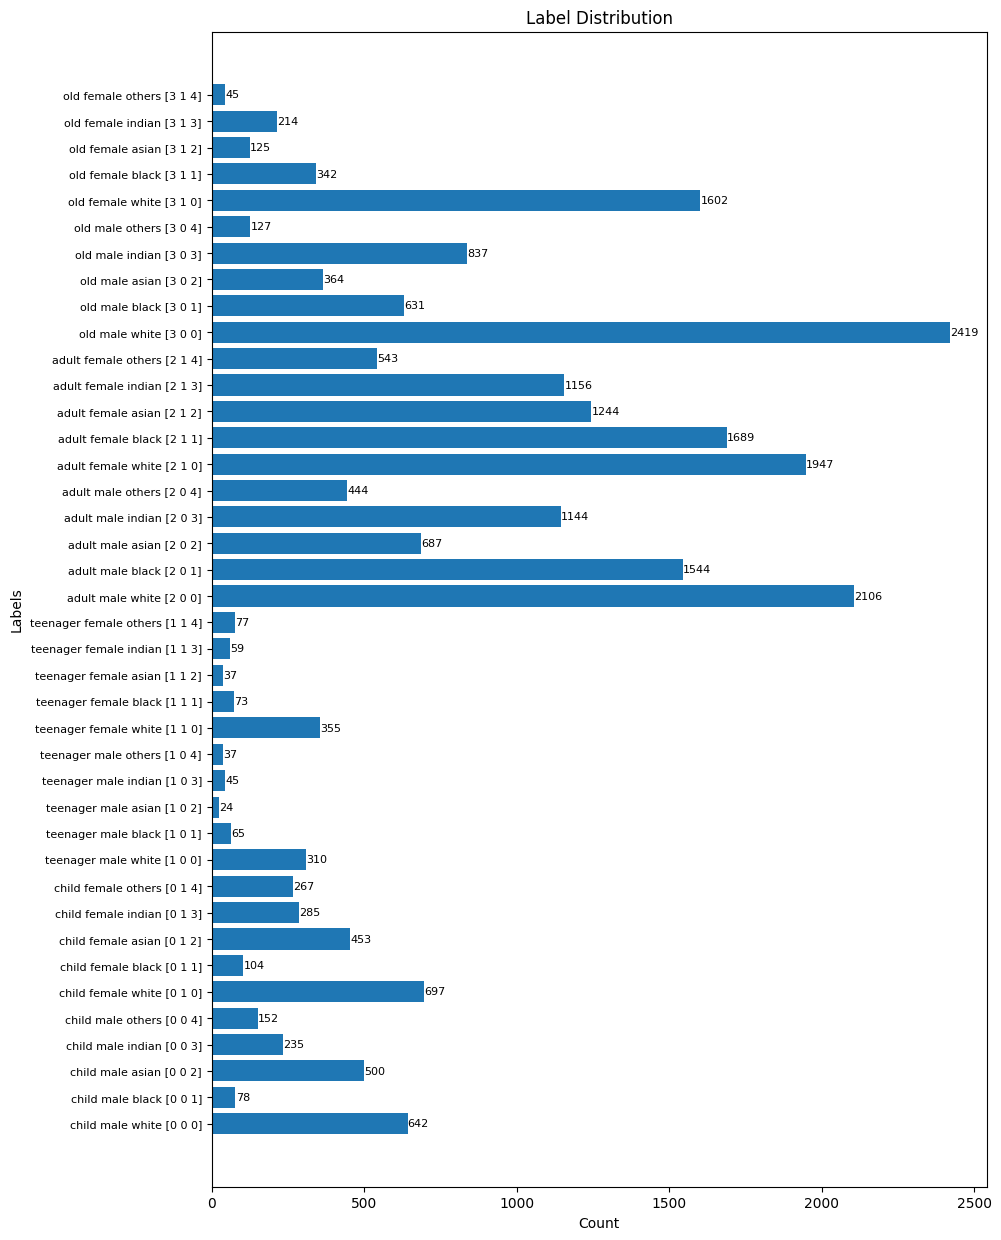

In [48]:
plot_label_distribution(df_data[['age_group','gender', 'race']])

In [49]:
def load_single_image(df, i, base_dir):
    image = cv2.imread(os.path.join(base_dir,df['image'][i]),cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(150,150))
    label = [df['age_group'][i],df['gender'][i],df['race'][i]]
    return image, label

def load_image(df, base_dir):
    images = []
    labels = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
        for image, label in executor.map(load_single_image, [df]*len(df), range(len(df)), [base_dir]*len(df)):
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

In [50]:
images, labels = load_image(df_data, BASE_DIR)
images.shape, labels.shape

((23705, 150, 150, 3), (23705, 3))

In [51]:
def show_sample_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        axes[i].imshow(images[index])
        axes[i].set_title(f'{dict_age[labels[index][0]]}, {dict_gender[labels[index][1]]}, {dict_race[labels[index][2]]}', fontsize=8)
        axes[i].axis('off')
    plt.show()

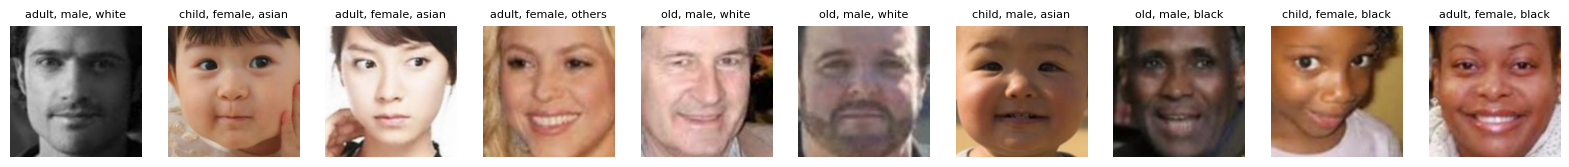

In [52]:
show_sample_images(images, labels)

In [53]:
def image_augmentation(images, labels, target_label, num_augmentations=5):
    augmented_images = []
    augmented_labels = []
    target_indices = [i for i, label in enumerate(labels) if np.array_equal(label, target_label)]
    target_images = tf.convert_to_tensor([images[i] for i in target_indices])
    target_labels = [labels[i] for i in target_indices]

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomWidth(0.1),
        tf.keras.layers.RandomHeight(0.1),
    ])

    for _ in range(num_augmentations):
        augmented_image_batch = data_augmentation(target_images)
        for augmented_image in augmented_image_batch:
            augmented_image = tf.image.resize(augmented_image, (150, 150))
            augmented_image = augmented_image / 255.0
            augmented_images.append(augmented_image.numpy())
            augmented_labels.append(target_label)

    return np.array(augmented_images), np.array(augmented_labels)

In [54]:
augmentation_params = [
    ([3, 1, 4], 10),
    ([3, 1, 3], 10),
    ([3, 1, 2], 10),
    ([3, 0, 4], 10),
    ([1, 1, 4], 10),
    ([1, 1, 3], 10),
    ([1, 1, 2], 10),
    ([1, 1, 1], 10),
    ([1, 0, 4], 10),
    ([1, 0, 3], 10),
    ([1, 0, 2], 10),
    ([1, 0, 1], 10),
    ([0, 1, 1], 10),
    ([0, 0, 4], 10),
    ([0, 0, 1], 10),
]

for target_label, num_augmentations in augmentation_params:
    augmented_images, augmented_labels = image_augmentation(images, labels, target_label, num_augmentations)
    images, labels = np.concatenate([images, augmented_images]), np.concatenate([labels, augmented_labels])

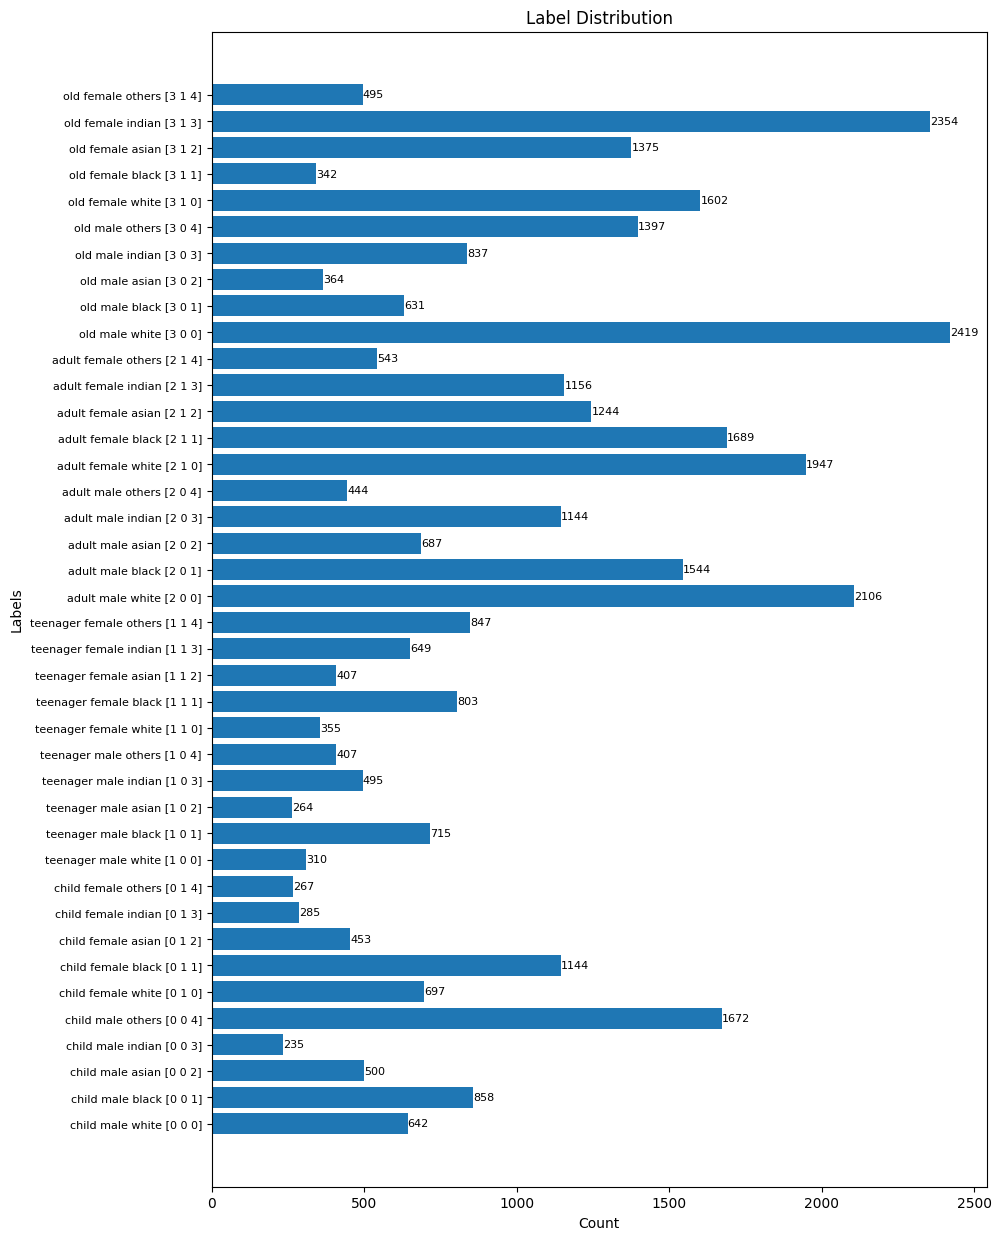

In [55]:
plot_label_distribution(labels)

In [56]:
def downsample(images, labels, n_samples):
    labels_as_tuples = [tuple(label) for label in labels]
    unique_labels = set(labels_as_tuples)
    downsampled_images = []
    downsampled_labels = []
    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels_as_tuples) if lbl == label]
        if len(indices) < n_samples:
            print(f"Warning: Class {label} only has {len(indices)} samples, less than {n_samples}")
            selected_indices = indices
        else:
            selected_indices = np.random.choice(indices, n_samples, replace=False)
        downsampled_images.extend(images[i] for i in selected_indices)
        downsampled_labels.extend(labels[i] for i in selected_indices)
    
    return np.array(downsampled_images), np.array(downsampled_labels)

In [57]:
# downsampled_images, downsampled_labels = downsample(images, labels, 600)
# downsampled_images.shape, downsampled_labels.shape

In [58]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train_1, y_train_2, y_train_3 = y_train[:,0], y_train[:,1], y_train[:,2]
y_test_1, y_test_2, y_test_3 = y_test[:,0], y_test[:,1], y_test[:,2]

In [59]:
with tf.device('/cpu:0'):
    x_train = tf.convert_to_tensor(x_train)
    x_test = tf.convert_to_tensor(x_test)
    y_train_1 = tf.convert_to_tensor(y_train_1)
    y_train_2 = tf.convert_to_tensor(y_train_2)
    y_train_3 = tf.convert_to_tensor(y_train_3)
    y_test_1 = tf.convert_to_tensor(y_test_1)
    y_test_2 = tf.convert_to_tensor(y_test_2)
    y_test_3 = tf.convert_to_tensor(y_test_3)


In [60]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

dense_1 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
outputs_1 = tf.keras.layers.Dense(5, activation='softmax', name='age')(dense_1)

dense_2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
outputs_2 = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(dense_2)

dense_3 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
outputs_3 = tf.keras.layers.Dense(5, activation='softmax', name='race')(dense_3)

model = tf.keras.models.Model(inputs=inputs, outputs=[outputs_1, outputs_2, outputs_3])
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 148, 148, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 74, 74, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

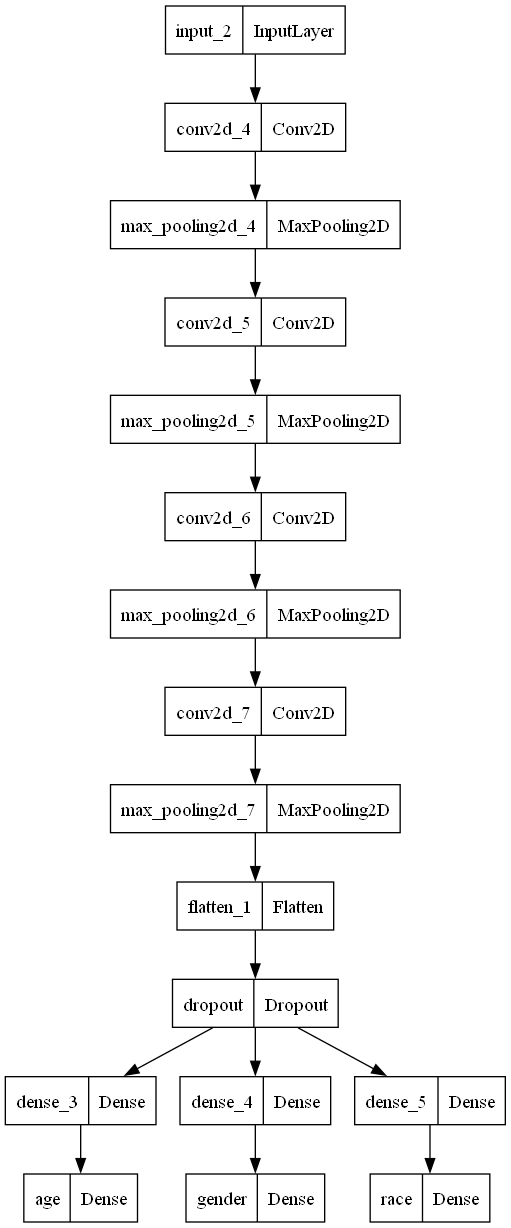

In [61]:
plot_model(model)

In [62]:
history = model.fit(x_train, [y_train_1, y_train_2, y_train_3], validation_data=(x_test, [y_test_1, y_test_2, y_test_3]), epochs=50, batch_size=32)

Epoch 1/50
909/909 [==============================] - 193s 209ms/step - loss: 3.8973 - age_loss: 1.0467 - gender_loss: 0.6137 - race_loss: 1.2833 - age_accuracy: 0.5858 - gender_accuracy: 0.6991 - race_accuracy: 0.4942 - val_loss: 2.9260 - val_age_loss: 0.7879 - val_gender_loss: 0.4512 - val_race_loss: 1.0037 - val_age_accuracy: 0.6658 - val_gender_accuracy: 0.7792 - val_race_accuracy: 0.5993
Epoch 2/50
909/909 [==============================] - 50s 54ms/step - loss: 2.8254 - age_loss: 0.7467 - gender_loss: 0.4682 - race_loss: 1.0300 - age_accuracy: 0.6860 - gender_accuracy: 0.7608 - race_accuracy: 0.5879 - val_loss: 2.4762 - val_age_loss: 0.6438 - val_gender_loss: 0.4178 - val_race_loss: 0.9002 - val_age_accuracy: 0.7430 - val_gender_accuracy: 0.7955 - val_race_accuracy: 0.6509
Epoch 3/50
909/909 [==============================] - 49s 54ms/step - loss: 2.5400 - age_loss: 0.6762 - gender_loss: 0.4363 - race_loss: 0.9472 - age_accuracy: 0.7214 - gender_accuracy: 0.7853 - race_accuracy: 

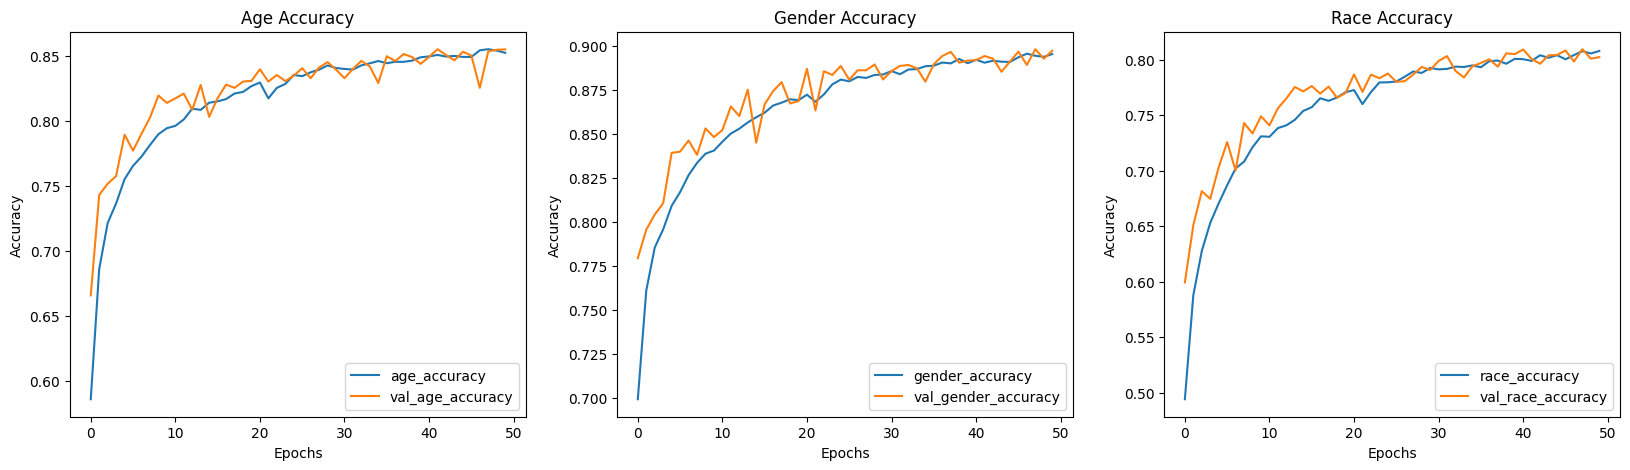

In [63]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['age_accuracy'], label='age_accuracy')
plt.plot(history.history['val_age_accuracy'], label='val_age_accuracy')
plt.title('Age Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['gender_accuracy'], label='gender_accuracy')
plt.plot(history.history['val_gender_accuracy'], label='val_gender_accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['race_accuracy'], label='race_accuracy')
plt.plot(history.history['val_race_accuracy'], label='val_race_accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [65]:
y_pred = model.predict(x_test)
y_pred_age = np.argmax(y_pred[0], axis=1)
y_pred_gender = np.round(y_pred[1])
y_pred_race = np.argmax(y_pred[2], axis=1)

228/228 [==============================] - 3s 14ms/step


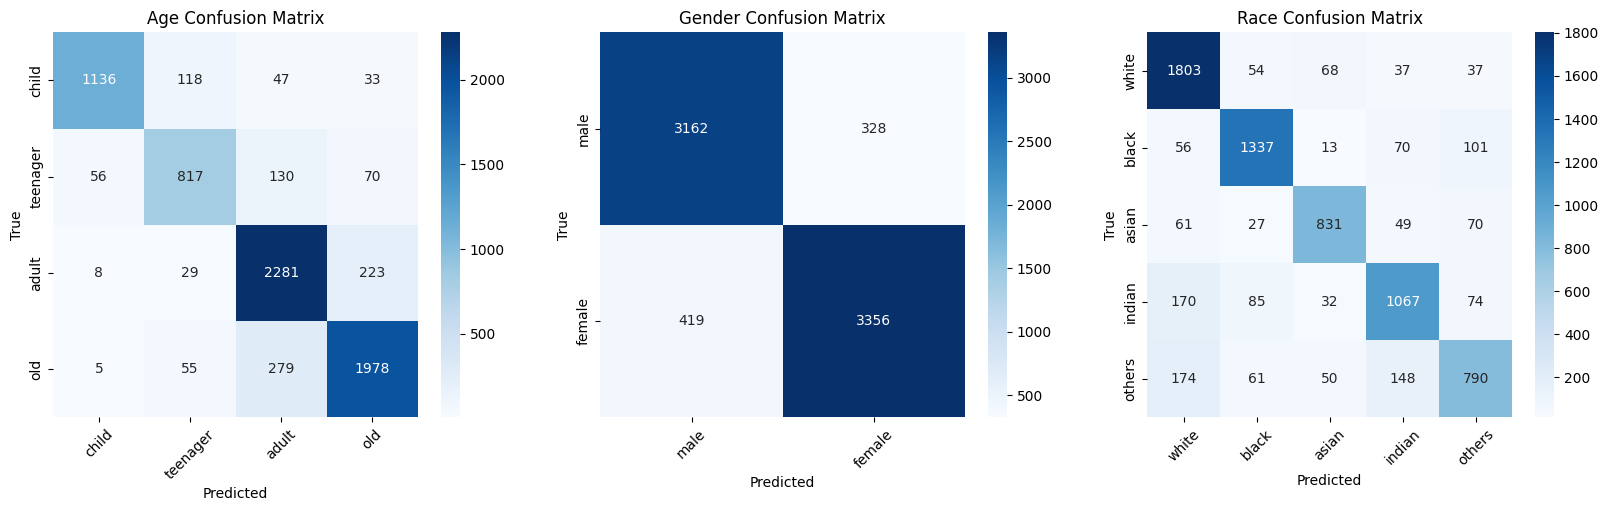

In [66]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test_1, y_pred_age), annot=True, fmt='d', cmap='Blues', xticklabels=dict_age.values(), yticklabels=dict_age.values())
plt.title('Age Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test_2, y_pred_gender), annot=True, fmt='d', cmap='Blues', xticklabels=dict_gender.values(), yticklabels=dict_gender.values())
plt.title('Gender Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test_3, y_pred_race), annot=True, fmt='d', cmap='Blues', xticklabels=dict_race.values(), yticklabels=dict_race.values())
plt.title('Race Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.show()

In [67]:
print(classification_report(y_test_1, y_pred_age, target_names=dict_age.values()))

              precision    recall  f1-score   support

       child       0.94      0.85      0.89      1334
    teenager       0.80      0.76      0.78      1073
       adult       0.83      0.90      0.86      2541
         old       0.86      0.85      0.86      2317

    accuracy                           0.86      7265
   macro avg       0.86      0.84      0.85      7265
weighted avg       0.86      0.86      0.86      7265



In [68]:
print(classification_report(y_test_2, y_pred_gender, target_names=dict_gender.values()))

              precision    recall  f1-score   support

        male       0.88      0.91      0.89      3490
      female       0.91      0.89      0.90      3775

    accuracy                           0.90      7265
   macro avg       0.90      0.90      0.90      7265
weighted avg       0.90      0.90      0.90      7265



In [69]:
print(classification_report(y_test_3, y_pred_race, target_names=dict_race.values()))

              precision    recall  f1-score   support

       white       0.80      0.90      0.85      1999
       black       0.85      0.85      0.85      1577
       asian       0.84      0.80      0.82      1038
      indian       0.78      0.75      0.76      1428
      others       0.74      0.65      0.69      1223

    accuracy                           0.80      7265
   macro avg       0.80      0.79      0.79      7265
weighted avg       0.80      0.80      0.80      7265



In [64]:
model.save('model_age_gender_race.h5')

In [ ]:
model.save_wieghts('checkpoint/cp_1.ckpt')